In [1]:
# 필요한 패키지
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as k
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPool2D,Flatten,Dense,Dropout

In [2]:
class CNN(Model):
  def __init__(self, nb_class):
    super(CNN,self).__init__()
    self.nb_class = nb_class
    self.conv2D_1 = Conv2D(32,(3,3),activation='relu')
    self.conv2D_2 = Conv2D(64,(3,3),activation='relu')
    self.maxpool2d = MaxPool2D()
    self.dropOut_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense1 = Dense(128,activation='relu')
    self.dropOut_2 = Dropout(0.5)
    self.dense2 = Dense(nb_class,activation='softmax')
  def call(self,x):    
    h = self.conv2D_1(x)
    h = self.conv2D_2(h)
    h = self.maxpool2d(h)
    h = self.dropOut_1(h)
    h = self.flatten(h)
    h = self.dense1(h)
    h = self.dropOut_2(h)
    h = self.dense2(h)
    return h

In [3]:
nb_classes = 10
model = CNN(nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
# 데이터 준비
class DataSet():
  def __init__(self,x,y,nb_classes, scaling=True,test_size=0.2,random_state=0):
    self.x = x
    self.add_channels()
    x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=test_size,random_state=random_state)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    if scaling:
      scale = MinMaxScaler()      
      n = x_train.shape[0]
      x_train = scale.fit_transform( x_train.reshape(n,-1)).reshape(x_train.shape)
      n = x_test.shape[0]
      x_test = scale.transform( x_test.reshape(n,-1)).reshape(x_test.shape)
      self.scaler = scale
    print(f'x_train shape :{x_train.shape}')
    print(f'{x_train.shape[0]} : train samples')
    print(f'{x_test.shape[0]} : test samples')

    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    self.x_train,self.y_train,self.x_test,self.y_test = x_train,y_train,x_test,y_test
  def add_channels(self):
    x = self.x
    if len(x.shape) == 3:
      N, img_rows, img_cols = x.shape
      if K.img_dim_ordering() == 'th':
        x = x.reshape(x.shape[0],1,img_rows,img_cols)
        input_shape = (1,img_rows,img_cols)
      else:
        x = x.reshape(x.shape[0],img_rows,img_cols,1)
        input_shape = (img_rows,img_cols,1)
    else:
      input_shape = x.shape[1:]
    self.x = x
    self.input_shape = input_shape    

In [5]:
from tensorflow.keras import datasets
(x,y),(x_test,y_test)  = datasets.cifar10.load_data()
np_classes = 10
data = DataSet(x,y,nb_classes)
data.input_shape

x_train shape :(40000, 32, 32, 3)
40000 : train samples
10000 : test samples


(32, 32, 3)

In [6]:
data.x_train.shape,  data.y_train.shape, data.x_test.shape, data.y_test.shape

((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

In [7]:
# epochs=2
# batch_size=128
# verbose = 1
# model.fit(data.x_train,data.y_train,batch_size=batch_size, 
#                     epochs=epochs,verbose=verbose, validation_data=(data.x_test,data.y_test) )


In [16]:
# 학습 및 성능평가를 위한 클래스
from datetime import datetime
class Machine():  # 부모클래스 
  def __init__(self,x,y,nb_classes=2,fig=True):
    self.nb_classes = nb_classes
    self.set_data(x,y)
    self.set_model()
    self.fig = fig
  def set_data(self,x,y):
    np_classes = self.nb_classes
    self.data = DataSet(x,y,nb_classes)
  def set_model(self):
    np_classes = self.nb_classes
    data = self.data
    self.model = CNN(np_classes)
    self.model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  def fit(self, nb_epoch=10, batch_size=128, verbose=1):
    data = self.data
    model = self.model
    print(f'0001  {data.x_train.shape} {data.y_train.shape}')
    history = model.fit(data.x_train, data.y_train,batch_size=batch_size,
                        epochs=nb_epoch,verbose=verbose,validation_data=(data.x_test,data.y_test))
    return history
  # 학습과 평가를 진행  
  def run(self, nb_epoch=10, batch_size=128,verbose=1):
    data = self.data
    model = self.model
    fig = self.fig
    history = self.fit(nb_epoch=nb_epoch,batch_size=batch_size,verbose=verbose)
    print(f'test data shapes = {data.x_test.shape}, {data.y_test.shape}')
    score = model.evaluate(data.x_test,data.y_test,verbose=0)
    print('Confusion matrix')
    Y_test_pred =  model.predict(data.x_test,verbose=0)
    y_test_pred  = np.argmax(Y_test_pred,axis=1)
    
    print(f'test target shape : {data.y_test.shape} / test pred shape : {y_test_pred.shape}')

    print(metrics.confusion_matrix(np.argmax(data.y_test,axis=1), y_test_pred))
    print(f'Test loss : {score[0]}')
    print(f'Test accuracy : {score[1]}')
    # 학습곡선과 생성될 모델을 분석하기 위해서 저장
    now = datetime.now()
    formatted_now = now.strftime("%Y_%m_%d_%H_%M_%S")
    foldname = './output_'+ formatted_now
    os.makedirs(foldname)
    # 학습곡선을 저장
    # 가중치 저장
    model.save_weights(os.path.join(foldname,'dl_model.h5'))
    print(f'ouput results are saved in {foldname}')
    if fig:
      plt.figure(figsize = (12,4))
      plt.subplot(1,2,1)
      plt.plot(history.history['loss'],label='Train loss')
      plt.plot(history.history['val_loss'],label='Val loss')
      plt.subplot(1,2,2)
      plt.plot(history.history['accuracy'],label='Train Accuracy')
      plt.plot(history.history['val_accuracy'],label='Val Accuracy')
      plt.show()
    self.history =history

In [17]:
from datetime import datetime
now = datetime.now()
formatted_now = now.strftime("%Y_%m_%d_%H_%M_%S")
print(formatted_now)

2023_05_16_12_03_57


In [18]:
# 적용
class ColorMachine(Machine):
  def __init__(self):
    (x_train,y_train),(x_test,y_test) =  datasets.cifar10.load_data()
    super().__init__(x_train,y_train,nb_classes=10)

x_train shape :(40000, 32, 32, 3)
40000 : train samples
10000 : test samples
0001  (40000, 32, 32, 3) (40000, 10)
Epoch 1/10
313/313 [==============================] - 6s 15ms/step - loss: 1.6873 - accuracy: 0.3939 - val_loss: 1.2923 - val_accuracy: 0.5479
Epoch 2/10
313/313 [==============================] - 4s 14ms/step - loss: 1.3428 - accuracy: 0.5204 - val_loss: 1.1238 - val_accuracy: 0.6042
Epoch 3/10
313/313 [==============================] - 4s 13ms/step - loss: 1.2061 - accuracy: 0.5733 - val_loss: 1.0637 - val_accuracy: 0.6253
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 1.1198 - accuracy: 0.6066 - val_loss: 1.0137 - val_accuracy: 0.6467
Epoch 5/10
313/313 [==============================] - 4s 14ms/step - loss: 1.0643 - accuracy: 0.6215 - val_loss: 0.9937 - val_accuracy: 0.6504
Epoch 6/10
313/313 [==============================] - 4s 14ms/step - loss: 0.9989 - accuracy: 0.6476 - val_loss: 0.9346 - val_accuracy: 0.6647
Epoch 7/10
313/313 [========

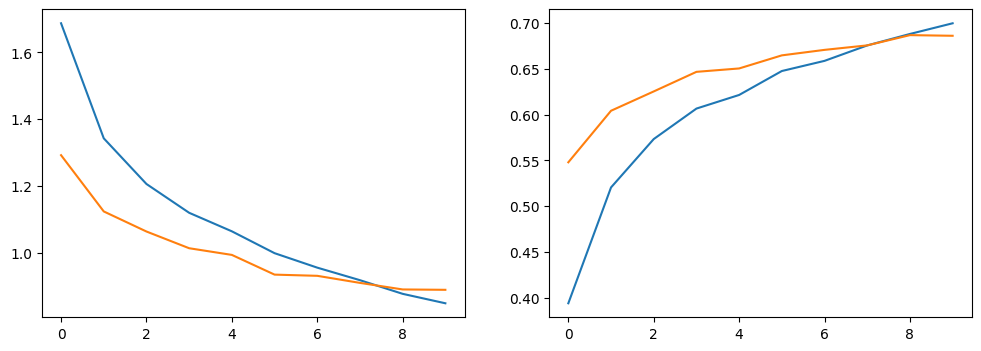

In [19]:
m = ColorMachine()
m.run()